In [ ]:
!pip install tf-nightly
!pip install tf-hub-nightly
!pip install tensorflow==2.0.0-alpha
!pip install 'tensorflow-hub == 0.5' 

     |████████████████████████████████| 483.4 MB 11 kB/s 
     |████████████████████████████████| 1.3 MB 41.1 MB/s 
     |████████████████████████████████| 5.8 MB 8.0 MB/s 
     |████████████████████████████████| 12.8 MB 148 kB/s 
     |████████████████████████████████| 2.3 MB 72.9 MB/s 
     |████████████████████████████████| 463 kB 57.6 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires flatbuffers~=1.12.0, but you have flatbuffers 2.0 which is incompatible.
     |████████████████████████████████| 109 kB 5.1 MB/s 
     |████████████████████████████████| 80.3 MB 18 kB/s 
     |████████████████████████████████| 411 kB 57.1 MB/s 
     |████████████████████████████████

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers



/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [3]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")


Version:  2.0.0-alpha0
Eager mode:  True
Hub version:  0.5.0
GPU is NOT AVAILABLE


In [4]:
data_dir = os.path.join('', '/content/rice')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')


In [5]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + " files"


In [6]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))


total images for training : /content/rice/train : 78 files
total images for validation : /content/rice/validation : 67 files


In [8]:
import json

with open('/content/rice/classes.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Bacterial_leaf_blight', 'blast']


In [9]:
print('Number of classes:',len(classes))

Number of classes: 2


In [10]:
file_path1 = ('/content/rice/validation/.ipynb_checkpoints')
file_path2 = ('/content/rice/train/.ipynb_checkpoints')
os.rmdir(file_path1)
os.rmdir(file_path2)

In [ ]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 #@param {type:"integer"}

In [38]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


Found 67 images belonging to 2 classes.
Found 78 images belonging to 2 classes.


In [39]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])




In [40]:
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False
    

In [41]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
Total params: 22,852,898
Trainable params: 1,050,114
Non-trainable params: 21,802,784
_________________________________________________________________


In [42]:
LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy']) 



In [44]:

EPOCHS=30 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/30
1/1 [==============================] - 19s 19s/step - loss: 1.4203 - accuracy: 0.7143 - val_loss: 0.4386 - val_accuracy: 0.8125
Epoch 2/30
1/1 [==============================] - 32s 32s/step - loss: 0.6873 - accuracy: 0.6094 - val_loss: 0.3863 - val_accuracy: 0.8125
Epoch 3/30
1/1 [==============================] - 29s 29s/step - loss: 0.4549 - accuracy: 0.7656 - val_loss: 0.7436 - val_accuracy: 0.6875
Epoch 4/30
1/1 [==============================] - 19s 19s/step - loss: 1.0265 - accuracy: 0.7857 - val_loss: 0.4590 - val_accuracy: 0.8281
Epoch 5/30
1/1 [==============================] - 17s 17s/step - loss: 0.6982 - accuracy: 0.7857 - val_loss: 0.4455 - val_accuracy: 0.7656
Epoch 6/30
1/1 [==============================] - 29s 29s/step - loss: 0.5079 - accuracy: 0.7188 - val_loss: 0.4196 - val_accuracy: 0.7656
Epoch 7/30
1/1 [==============================] - 27s 27s/step - loss: 0.3667 - accuracy: 0.8438 - val_loss: 0.3911 - val_accuracy: 0.8594
Epoch 8/30
1/1 [===========

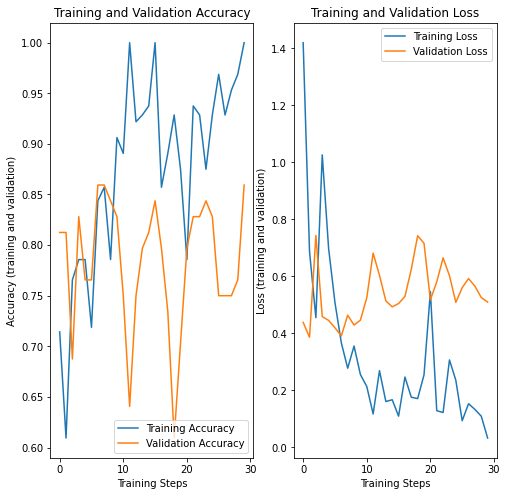

In [45]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [46]:
import cv2
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: blast, file: blast/blast_rotated_018.png
PREDICTED: class: blast, confidence: 0.969457


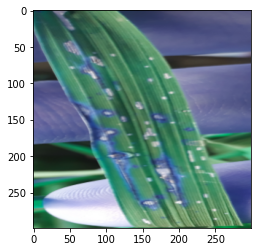

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_005.jpg
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.755413


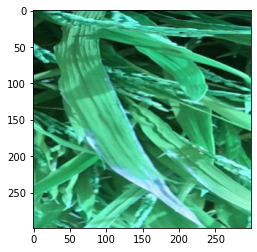

SOURCE: class: blast, file: blast/blast_rotated_004.png
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.554013


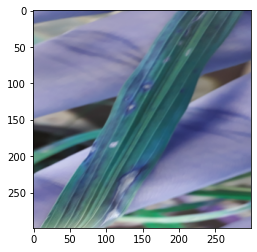

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_013.jpg
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.987532


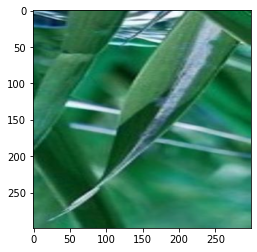

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_034.jpg
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.948427


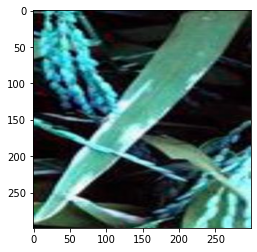

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_015.jpg
PREDICTED: class: blast, confidence: 0.712649


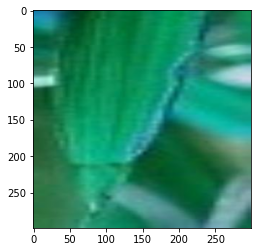

<Figure size 432x288 with 0 Axes>

SOURCE: class: blast, file: blast/blast_rotated_023.jpg
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.568150


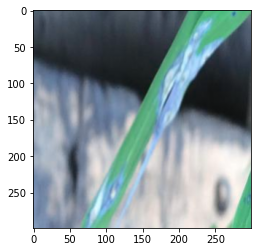

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_001.jpg
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.987532


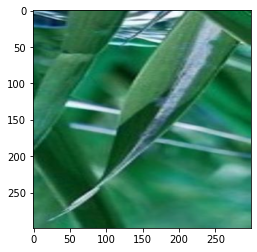

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_018.png
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.739769


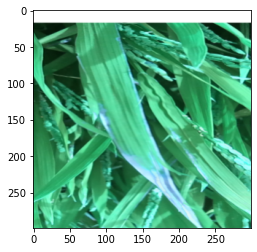

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_008.PNG
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.613087


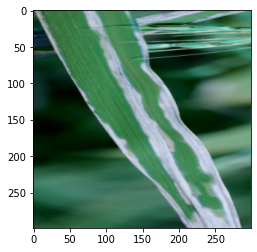

<Figure size 432x288 with 0 Axes>

SOURCE: class: blast, file: blast/blast_rotated_012.png
PREDICTED: class: blast, confidence: 0.917018


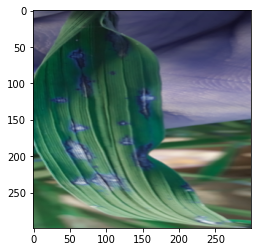

<Figure size 432x288 with 0 Axes>

SOURCE: class: blast, file: blast/blast_rotated_022.png
PREDICTED: class: blast, confidence: 0.988808


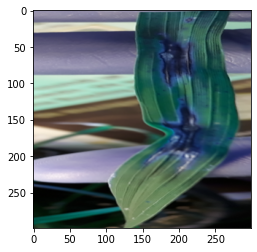

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_024.PNG
PREDICTED: class: blast, confidence: 0.951952


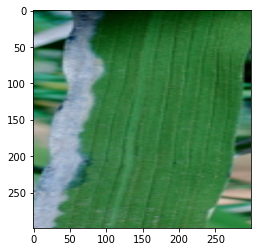

<Figure size 432x288 with 0 Axes>

SOURCE: class: blast, file: blast/blast_rotated_006.png
PREDICTED: class: blast, confidence: 0.998928


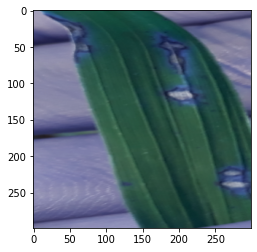

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_025.jpg
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.932986


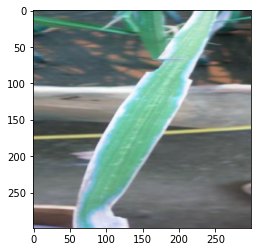

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_043.jpg
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.787335


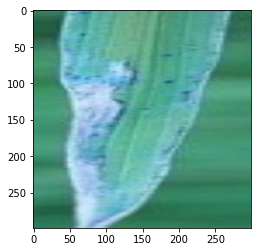

<Figure size 432x288 with 0 Axes>

SOURCE: class: blast, file: blast/blast_rotated_002.png
PREDICTED: class: blast, confidence: 0.797451


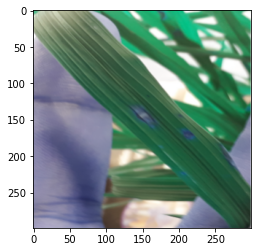

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_019.jpg
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.988670


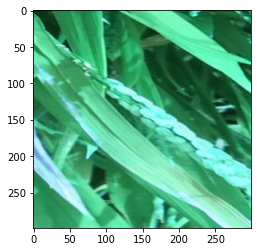

<Figure size 432x288 with 0 Axes>

SOURCE: class: blast, file: blast/blast_rotated_014.png
PREDICTED: class: blast, confidence: 0.993106


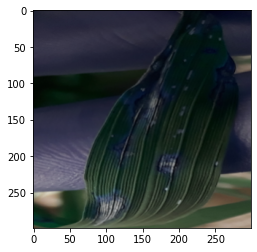

<Figure size 432x288 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_006.PNG
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.794408


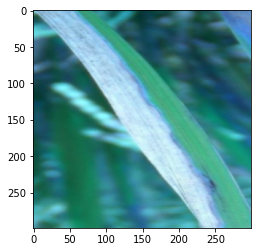

<Figure size 432x288 with 0 Axes>

In [47]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 20)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()